# Description:

* Demultiplexing libraries from MiSeq run

## Setting variables (user input)

In [1]:
## Where are your raw sequences found?
seqdir = '/home/backup_files/raw_reads/hempmicrobiome.Sam.Ali.SmartLab.2018/'

## What directory do you want to work in and keep all subsequent files in?
workdir = '/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult/'

# metadata file location(s)
metadata = '/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/ITS_hemp_metadata_final.txt'

# What are your index files called?
index_read1_file = 'index1.ITS.fq.gz'
index_read2_file = 'index2.ITS.fq.gz'

# What is your merged read dictionary called? You made that in the previous notebook.
read12_screed = 'pear_merged_hemp_ITS.assembled.fastq_screed'

# What do you want your index dictionaries to be called?
index_read1_screed = 'index1.ITS.fq_screed'
index_read2_screed = 'index2.ITS.fq_screed'

## Init

In [2]:
import os
import json
import screed
import pandas as pd
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy.stats as stats
import screed
from glob import glob

In [3]:
if not os.path.isdir(workdir):
    print ("Working directory does not exist")
%cd $workdir

/home/sam/notebooks/hemp_microbiome/data/ITS_OTUs/merge_demult


In [4]:
%load_ext rpy2.ipython
#%load_ext pushnote 

In [5]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)

/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: 
Attaching package: ‘dplyr’


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  warnings.warn(x, RRuntimeWarning)
/home/sam/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  warnings.warn(x, RRuntimeWarning)


## Loading metadata tables

In [6]:
# loading metadata sheet
df_meta = pd.read_csv(metadata, delimiter="\t")
print(df_meta.head(n=3))

  sample_ID  Extraction_plate Extraction_plate_well  Dilution_plate  \
0    1-2-RT  hemp_DNAx_plate1                    A1  hemp_DI_plate1   
1     6-5-F  hemp_DNAx_plate1                    B1  hemp_DI_plate1   
2     2-3-L  hemp_DNAx_plate1                    C1  hemp_DI_plate1   

  Dilution_plate_well  PCR_run  PCR_order  Primer        Library     Exp_type  \
0                  A1        1          1       1  hemp_library1  whole_plant   
1                  B1        1          2       2  hemp_library1  whole_plant   
2                  C1        1          3       3  hemp_library1  whole_plant   

      ...       Sample_type  Week  Sex  DNA_conc Date_extracted  DI_factor  \
0     ...       root_tissue   NaN  NaN     1.712         180111      1.712   
1     ...           flowers   NaN  NaN     0.065         180111      1.000   
2     ...            leaves   NaN  NaN     0.126         180111      1.000   

   Sequenced_16S  Sequenced_ITS  fwd_barcode  rev_barcode  
0           True 

# Uncompress index files and create screed db

In [7]:
def uncomp(fileName, directory):
    output = fileName.replace(".gz", "")
    fileName = os.path.join(directory, fileName)
    !cd $workdir; \
        pigz -k -d -p 24 -c -f $fileName > $output
    return os.path.splitext(output)[0]
    
index_read1_file = uncomp(index_read1_file, seqdir)
index_read2_file = uncomp(index_read2_file, seqdir)

In [8]:
os.chdir(workdir)
screed.read_fastq_sequences(index_read1_file+".fq")
screed.read_fastq_sequences(index_read2_file+".fq")

index_read1_screed = index_read1_file + '.fq_screed'
index_read2_screed = index_read2_file + '.fq_screed'

# Demultiplex

In [9]:
# rev-comp functions
def complement(seq): 
    idx = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N'} 
    idx.update( {x.lower():y.lower() for x,y in idx.items()} )
    return ''.join(idx[x] for x in list(seq))

def revComp(seq):
    seq = seq[::-1]
    return complement(seq)    

In [10]:
# loading/editing metadata

df_meta.columns = ['Sample'] + list((df_meta.columns)[1:])

df_meta['Barcode_FR'] = [(revComp(y) + x).lower() for x,y \
                         in zip(df_meta.fwd_barcode,df_meta.rev_barcode)]


## format of barcode=>sample dict: [revBarcode=read1 + fwdBarcode=read2] : sampleID
map_d = {x:y for x,y in zip(df_meta.Barcode_FR, df_meta.Sample)}

In [13]:
# resulting dict of sample => barcode_FR 
n_print = 182
[(list(map_d.keys())[i], map_d[list(map_d.keys())[i]]) for i in range(n_print)]

[('cgagagttatcgtacg', '1-2-RT'),
 ('cgagagttactatctg', '6-5-F'),
 ('cgagagtttagcgagt', '2-3-L'),
 ('cgagagttctgcgtgt', '1-4-RS'),
 ('cgagagtttcatcgag', 'F2-1'),
 ('cgagagttcgtgagtg', 'M5-3'),
 ('cgagagttggatatct', '3-3-BS'),
 ('cgagagttgacaccgt', '6-1-RT'),
 ('gacatagtatcgtacg', '5-5-BS'),
 ('gacatagtactatctg', 'F4-2'),
 ('gacatagttagcgagt', '5-3-RS'),
 ('gacatagtctgcgtgt', 'extraction_water_control1'),
 ('gacatagttcatcgag', '1-2-L'),
 ('gacatagtcgtgagtg', 'F5-1'),
 ('gacatagtggatatct', '1-4-RT'),
 ('gacatagtgacaccgt', '6-3-BS'),
 ('acgctactatcgtacg', '4-3-BS'),
 ('acgctactactatctg', '3-3-L'),
 ('acgctacttagcgagt', '3-4-BS'),
 ('acgctactctgcgtgt', 'M2-3'),
 ('acgctacttcatcgag', '2-3-F'),
 ('acgctactcgtgagtg', 'F1-3'),
 ('acgctactggatatct', '6-1-F'),
 ('acgctactgacaccgt', '4-4-L'),
 ('actcactgatcgtacg', '4-3-L'),
 ('actcactgactatctg', '2-4-RS'),
 ('actcactgtagcgagt', '4-4-RS'),
 ('actcactgctgcgtgt', '3-4-L'),
 ('actcactgtcatcgag', '4-5-F'),
 ('actcactgcgtgagtg', '2-4-BS'),
 ('actcactggg

In [14]:
# loading screed databases 
ir1db = screed.ScreedDB(index_read1_screed)
ir2db = screed.ScreedDB(index_read2_screed)
amp_db = screed.ScreedDB(read12_screed)

In [15]:
# demultiplexing: naming reads by sample

outFile = re.sub('fastq_screed', 'dmult.fastq', read12_screed)

counter = 0
unassigned = 0
cnt = Counter()
outFile = os.path.join(workdir, os.path.split(outFile)[1])
c = 0
with open(outFile, "w") as out:
    for rec in amp_db.itervalues():
        index_concat = ir1db[rec["name"]]["sequence"] + ir2db[rec["name"]]["sequence"]
        
        try:
            new_name = map_d[index_concat.lower()] + "_" + str(counter) #case sensitive
        except KeyError:
            unassigned += 1
            continue
        counter += 1
        cnt[map_d[index_concat.lower()]] += 1 #case sensitive
        s, q = rec["sequence"], rec["quality"]
        out.write("@%s orig_name=%s\n%s\n+\n%s\n"%(new_name,rec["name"],s,q))
        
        
print ("Unable to assign %s reads to samples"%unassigned)

Unable to assign 3914122 reads to samples


In [16]:
print ("Unable to assign %s reads to samples"%unassigned)

Unable to assign 3914122 reads to samples


In [17]:
# number of sequences
n_lines = !wc -l $outFile
n_lines = int(re.sub(' .+', '', n_lines[0]))
print('Number of sequences: {}'.format(n_lines/4))

Number of sequences: 10581210.0


# Stats on sequences

## Number of sequences per sample

In [18]:
# counting sequences for each sample
re_seqName = re.compile(r'_\d+ orig_name.+')

seq_cnt = dict()
with open(outFile, 'r') as fn:
    for line in fn.readlines():
        if re.search(re_seqName, line):
            sampleName = re.sub(re_seqName, '', line).rstrip().lstrip('@')
            try:
                seq_cnt[sampleName] += 1
            except KeyError:
                seq_cnt[sampleName] = 1 

In [19]:
# converting to dataframe
df_seq_cnt = pd.DataFrame.from_dict(seq_cnt, orient='index')
df_seq_cnt.index.name = 'Sample'
df_seq_cnt.reset_index(inplace=True)
df_seq_cnt.columns = ['Sample', 'seq_count']
df_seq_cnt

,Sample,seq_count
0,2-5-RT,132629
1,3-4-L,74699
2,4-1-RT,225184
3,3-1-RT,303506
4,2-3-L,91112
5,6-5-RT,110922
6,1-4-RT,100502
7,2-2-F,103780
8,6-3-RT,187798
9,M5-1,27629


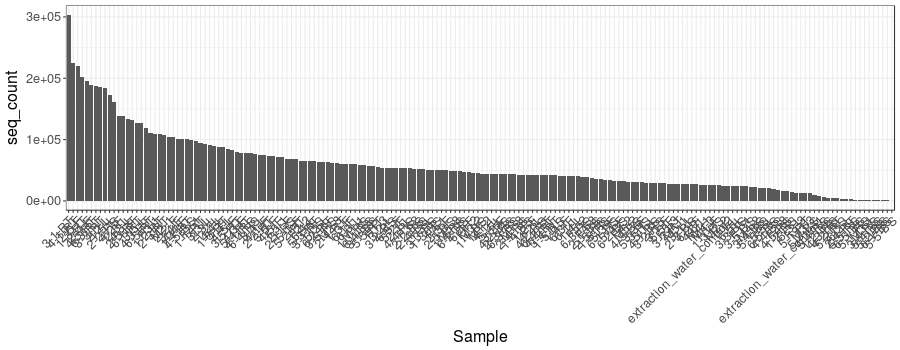

In [20]:
%%R -i df_seq_cnt -w 900 -h 350

df_seq_cnt$Sample = reorder(df_seq_cnt$Sample, desc(df_seq_cnt$seq_count))

ggplot(df_seq_cnt, aes(Sample, seq_count)) +
    geom_bar(stat='identity') +
    theme_bw() +
    theme( 
        text = element_text(size=16),
        axis.text.x = element_text(angle=45, hjust=1)
    )

In [21]:
%%R
df_seq_cnt[df_seq_cnt$seq_count < 10000,]

                       Sample seq_count
80                     5-3-BS      9850
99  extraction_water_control1      7681
153                    5-2-RS      3684
164                    4-3-RS      4685
168                    5-1-RS      1534
169                    1-2-BS      5446
170                    2-4-RT      2680
171                    5-4-RS      5726
172                    5-5-RS      2092
173                     6-2-L      2982
174                    5-2-BS       734
175                      M3-1      1417
176                    5-4-BS      1063
177                    3-4-RS      1415
178                    6-1-BS       734
179                    4-2-RT      4340
180                    6-5-BS      1826
181                    5-5-BS       214


In [23]:
%%R
df_seq_cnt %>% arrange(-seq_count)

                       Sample seq_count
1                      3-1-RT    303506
2                      4-1-RT    225184
3                       2-5-F    220174
4                      1-3-RT    202554
5                       2-4-F    195432
6                      4-5-RT    188256
7                      6-3-RT    187798
8                      3-3-RT    185114
9                       2-2-L    183333
10                      1-5-L    173255
11                     2-2-RS    161482
12                      4-2-F    138820
13                      2-5-L    138073
14                      4-3-L    134247
15                     2-5-RT    132629
16                     6-1-RT    127063
17                      3-5-L    126754
18                     4-3-RT    118279
19                     6-5-RT    110922
20                       F3-1    108938
21                     1-2-RT    108676
22                     2-3-RT    106945
23                       M2-1    104396
24                      2-2-F    103780
